In [1]:
# 01_relation_similarity_analysis
#
# created by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on March 4, 2023
# updated by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on March 4, 2023
#
# 该脚本展示了如何分析训练的关系嵌入.
#
# 需要的包:
#          numpy
#          csv
#          matplotlib
#          sklearn
#
# 需要的文件:
#          ../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_relation.npy
#          ../../data/drkg/relations.tsv
#
# 源教程链接: https://github.com/gnn4dr/DRKG/blob/master/embedding_analysis/Relation_similarity_analysis.ipynb

# DRKG Relation Embedding Similarity Analysis
 
这个 notebook 展示了如何分析训练的关系嵌入.

在这个例子中, 我们首先加载训练的嵌入向量, 然后将它们映射回原始的关系名, 最后应用两种方法分析它们:

- 投射嵌入进入低维空间并可视化它们的分布.
- 使用余弦距离分析关系间的相似程度.

In [2]:
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
!mkdir -p ./result

## Loading Relation ID Mapping

In [4]:
rel2id = {}
id2rel = {}

with open("../../data/drkg/relations.tsv", newline = '', encoding = 'utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','rel'])
    for row_val in reader:
        id = row_val['id']
        relation = row_val['rel']

        rel2id[relation] = int(id)
        id2rel[int(id)] = relation

print("Number of relations: {}".format(len(rel2id)))

Number of relations: 107


## Loading Relation Embeddings

In [5]:
rel_emb = np.load('../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_relation.npy')
print(rel_emb.shape)

(107, 200)


## General Relation Embedding Clustering

这里我们使用 t-SNE 将关系嵌入降维, 然后可视化它们的分布.

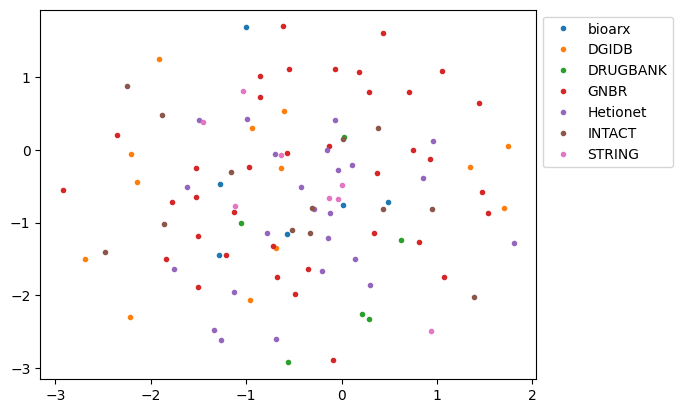

In [6]:
# 将关系按照源数据集分类
dataset_id = {}
for rel_name, i in rel2id.items():
    rel_key = rel_name.split('::')[0]
    if dataset_id.get(rel_key, None) is None:
        dataset_id[rel_key] = []
    dataset_id[rel_key].append(i)

# 降维并转置
X_embedded = TSNE(n_components=2).fit_transform(rel_emb).T

# 绘制
fig = plt.figure()
ax = fig.add_subplot(111)

for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    ax.plot(X_embedded[0][val], X_embedded[1][val], '.', label=key)

lgd = ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('./result/relation.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg')

## Pair-wise Relation Embedding Cosine Similarity

我们使用余弦距离计算成对的嵌入相似度, 然后输出最相似的 10 对.

In [7]:
# 计算余弦相似度
similarity = sklearn.metrics.pairwise.cosine_similarity(rel_emb)

# 在每一行上, 利用相似度将元素 Index 按降序排列
idx = np.flip(np.argsort(similarity), axis = 1)

max_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] > 0):
        max_pairs.append((id2rel[idx[i][0]], id2rel[idx[i][j]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

# 按照 score 降序 
max_pairs.sort(reverse=True, key = sort_score)

sim_pairs = []
for i, pair in enumerate(max_pairs):
    # 相似度矩阵是对称的, 因此有两个 score 完全一样的记录
    if i % 2 == 0:
        sim_pairs.append(pair)

# 输出 top 10
sim_pairs[:10]

[('Hetionet::DaG::Disease:Gene',
  'INTACT::ASSOCIATION::Compound:Gene',
  0.23346853),
 ('DRUGBANK::x-atc::Compound:Atc', 'GNBR::in_tax::Gene:Tax', 0.23311995),
 ('GNBR::L::Gene:Disease', 'Hetionet::DpS::Disease:Symptom', 0.22690767),
 ('DGIDB::BLOCKER::Gene:Compound', 'GNBR::J::Gene:Disease', 0.2268842),
 ('DGIDB::AGONIST::Gene:Compound',
  'INTACT::ASSOCIATION::Compound:Gene',
  0.22258793),
 ('DRUGBANK::enzyme::Compound:Gene', 'GNBR::Ud::Gene:Disease', 0.21916792),
 ('Hetionet::DpS::Disease:Symptom',
  'Hetionet::CbG::Compound:Gene',
  0.21718228),
 ('GNBR::N::Compound:Gene', 'Hetionet::GcG::Gene:Gene', 0.21505778),
 ('GNBR::W::Gene:Gene', 'Hetionet::CdG::Compound:Gene', 0.21384156),
 ('GNBR::Z::Compound:Gene', 'GNBR::in_tax::Gene:Tax', 0.21150547)]

然后, 我们绘制了成对相似度得分分布的直方图.

(11449,)


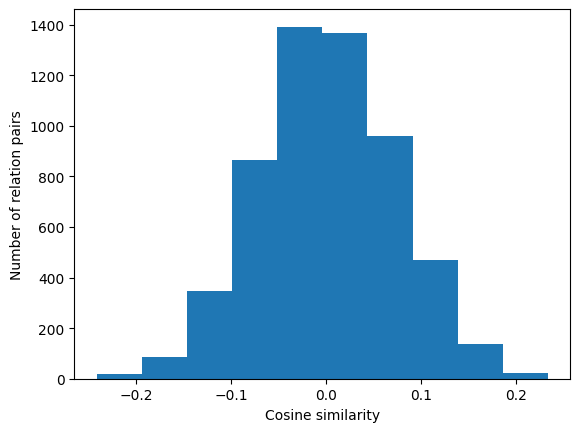

In [8]:
# 将相似度矩阵平铺
similarity = similarity.flatten()
print(similarity.shape)

# 清除 self-compare 和 dup-compare
s = similarity < 0.99
s = np.unique(similarity[s])

plt.xlabel('Cosine similarity')
plt.ylabel('Number of relation pairs')
plt.hist(s)
plt.savefig('./result/relation-sim.svg', format='svg')